# Using Mixup on TREC Dataset

## Import libraries

In [1]:
!pip install datasets
!python -m spacy download en_core_web_md

     |████████████████████████████████| 311 kB 5.2 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 133 kB 44.0 MB/s 
     |████████████████████████████████| 243 kB 32.7 MB/s 
     |████████████████████████████████| 1.1 MB 40.4 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 271 kB 37.4 MB/s 
     |████████████████████████████████| 144 kB 11.7 MB/s 
     |████████████████████████████████| 96.4 MB 1.4 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=d88efeee1c87331f213956e178fb07f12d96cf8147b79a360ad61b66b24aff62
  Stored in directory: /tmp/pip-ephem-wheel-cache-wla_fl7r/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility imports
import spacy
import re
import string
import time

# Extras
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from datasets import load_dataset # using 🤗 HugggingFace datasets library


## Set Random Seed

In [2]:
SEED = 420

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Load dataset

In [3]:
dataset = load_dataset("trec")

Using custom data configuration default
Reusing dataset trec (/root/.cache/huggingface/datasets/trec/default/1.1.0/751da1ab101b8d297a3d6e9c79ee9b0173ff94c4497b75677b59b61d5467a9b9)


  0%|          | 0/2 [00:00<?, ?it/s]

## Exploring the dataset

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label-coarse', 'label-fine', 'text'],
        num_rows: 5452
    })
    test: Dataset({
        features: ['label-coarse', 'label-fine', 'text'],
        num_rows: 500
    })
})


In [5]:
dataset.keys()

dict_keys(['train', 'test'])

In [6]:
print(dataset["train"].dataset_size)
print(dataset["train"].description)
print(dataset["train"].features)


413073
The Text REtrieval Conference (TREC) Question Classification dataset contains 5500 labeled questions in training set and another 500 for test set. The dataset has 6 labels, 47 level-2 labels. Average length of each sentence is 10, vocabulary size of 8700.

Data are collected from four sources: 4,500 English questions published by USC (Hovy et al., 2001), about 500 manually constructed questions for a few rare classes, 894 TREC 8 and TREC 9 questions, and also 500 questions from TREC 10 which serves as the test set.

{'label-coarse': ClassLabel(num_classes=6, names=['DESC', 'ENTY', 'ABBR', 'HUM', 'NUM', 'LOC'], names_file=None, id=None), 'label-fine': ClassLabel(num_classes=47, names=['manner', 'cremat', 'animal', 'exp', 'ind', 'gr', 'title', 'def', 'date', 'reason', 'event', 'state', 'desc', 'count', 'other', 'letter', 'religion', 'food', 'country', 'color', 'termeq', 'city', 'body', 'dismed', 'mount', 'money', 'product', 'period', 'substance', 'sport', 'plant', 'techmeth', 'vol

In [7]:
# Sample data point in TREC

dataset["train"][0]

{'label-coarse': 0,
 'label-fine': 0,
 'text': 'How did serfdom develop in and then leave Russia ?'}

In [8]:
train_df = pd.DataFrame(dataset["train"])
train_df.head()

,label-coarse,label-fine,text
0,0,0,How did serfdom develop in and then leave Russ...
1,1,1,What films featured the character Popeye Doyle ?
2,0,0,How can I find a list of celebrities ' real na...
3,1,2,What fowl grabs the spotlight after the Chines...
4,2,3,What is the full form of .com ?


In [9]:
test_df = pd.DataFrame(dataset["test"])
test_df.head()

,label-coarse,label-fine,text
0,4,40,How far is it from Denver to Aspen ?
1,5,21,"What county is Modesto , California in ?"
2,3,12,Who was Galileo ?
3,0,7,What is an atom ?
4,4,8,When did Hawaii become a state ?


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5452 entries, 0 to 5451
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label-coarse  5452 non-null   int64 
 1   label-fine    5452 non-null   int64 
 2   text          5452 non-null   object
dtypes: int64(2), object(1)
memory usage: 127.9+ KB


## Tokenize Data

In [11]:
nlp = spacy.load("en_core_web_md")

def tokenize(text):
	# text = re.sub(r"[^\x00-\x7F]+", "", str(text)) # remove non-ASCII characters
	# regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
	# no_punctuation = regex.sub(" ", text.lower())	
	# no_punctuation = re.sub(r"[^\w\s]", "", text.lower())
	
	text = re.sub('[^a-z ]+', '', text.lower()) # remove all non-alphabetic, non-space characters
	multiple_spaces = re.sub(' +', ' ', text.lower()) # convert multiple spaces to single
	
	return [token.text for token in nlp.tokenizer(text)]

In [12]:
train_df["text"] = train_df["text"].str.strip()
train_df.head()

,label-coarse,label-fine,text
0,0,0,How did serfdom develop in and then leave Russ...
1,1,1,What films featured the character Popeye Doyle ?
2,0,0,How can I find a list of celebrities ' real na...
3,1,2,What fowl grabs the spotlight after the Chines...
4,2,3,What is the full form of .com ?


In [13]:
# Initialize counter var and count occurence of words (rather tokens of the words) in the dataset

counts = Counter()
for index, row in train_df.iterrows():
  counts.update(tokenize(row["text"]))

In [14]:
print(f"# of words before: {len(counts.keys())}")

# Remove words that occur only once, and whitespaces
for word in list(counts):
  if counts[word] < 2:
    del counts[word]
  
  if ' ' in word:
    del counts[word]

print(f"# of words before: {len(counts.keys())}")

# of words before: 8319
# of words before: 3352


In [15]:
# Create a vocabulary from remaining words, and assign unknown to the removed words

vocab2index = {"": 0, "UNK": 1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [21]:
max_len = train_df['text'].str.split("\\s+").str.len().max()
min_len = train_df['text'].str.split("\\s+").str.len().min()

print(f"Max # of words: {max_len}\tMin # of words: {min_len}") 

Max # of words: 37	Min # of words: 3


In [22]:
# Function to encode sentences
def encode_sentence(text, vocab2index, N=80):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc))
    encoded[:length] = enc[:length]
    return encoded, length

In [23]:
# Apply encoding to train and test DataFrames
train_df["text"] = train_df["text"].apply(lambda x: np.array(encode_sentence(x, vocab2index)))
test_df["text"] = test_df["text"].apply(lambda x: np.array(encode_sentence(x, vocab2index)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
train_df.head()

,label-coarse,label-fine,text
0,0,0,"[[2, 3, 1, 4, 5, 6, 7, 8, 9, 0, 0, 0, 0, 0, 0,..."
1,1,1,"[[10, 11, 12, 13, 14, 15, 1, 0, 0, 0, 0, 0, 0,..."
2,0,0,"[[2, 16, 17, 18, 19, 20, 21, 22, 1, 23, 24, 0,..."
3,1,2,"[[10, 1, 1, 13, 1, 25, 13, 26, 27, 21, 13, 28,..."
4,2,3,"[[10, 29, 13, 30, 31, 21, 1, 0, 0, 0, 0, 0, 0,..."


### Load data into `Dataset` and then into `DataLoader`

In [32]:
# Custom Dataset class

class TRECDataset(Dataset):
  def __init__(self, text, label):
    self.x = text
    self.y = label
  
  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return torch.from_numpy(self.x[idx][0].astype(np.int32)), self.y[idx]

In [33]:
# Create Dataset from only text and coarse label columns

train_ds = TRECDataset(train_df["text"], train_df["label-coarse"])
test_ds = TRECDataset(test_df["text"], test_df["label-coarse"])

In [34]:
# Create dataloaders

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=True)

### Shifting data to GPU

In [35]:
# Functions to transfer data to GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
  """Wrap DataLoader to move batches of data to device"""
  def __init__(self, dataloader, device):
    self.dataloader = dataloader
    self.device = device
    
  def __len__(self):
    """Return number of batches"""
    return len(self.dataloader)
    
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for batch in self.dataloader:
      yield to_device(batch, self.device)

In [36]:
device = get_default_device()
device

device(type='cuda')

In [37]:
# Move dataloaders to cuda device

train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [38]:
# Check final data shape

for batch in train_dl:
    x, y = batch
    print(x.shape, y.shape)
    break

torch.Size([256, 80]) torch.Size([256])


In [39]:
vocab_size = len(words)
vocab_size

3354

## Building the model

In [48]:
class LSTMModel(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, 512, padding_idx=0)
        self.lstm = nn.LSTM(512, 512, batch_first=True, num_layers=2, bidirectional=True)
        self.linear1 = nn.Linear(512, 1024)
        self.linear2 = nn.Linear(1024, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 64)
        self.linear5 = nn.Linear(64, 6)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.LogSoftmax(dim=-1)
        
    def forward(self, x):
        # print(x.shape, " at start")
        x = self.embeddings(x)
        # print(x.shape, " after embeddings")
        _, (x, _) = self.lstm(x)
        # print(x.shape, " after lstm")

        # x = x.reshape(256, -1)
        # print(x.shape, " after reshape")
        
        x = F.relu(self.linear1(x[-1]))
        # print(x.shape, " after linear1")
        x = self.dropout(x)
        
        x = F.relu(self.linear2(x))
        # print(x.shape, " after linear2")
        x = self.dropout(x)
        
        x = F.relu(self.linear3(x))
        # print(x.shape, " after linear3")
        x = self.dropout(x)
        
        x = F.relu(self.linear4(x))
        # print(x.shape, " after linear4")
        x = self.dropout(x)
        
        x = F.relu(self.linear5(x))
        # print(x.shape, " after linear5")
        output = self.out(x)

        # print(x.shape, " after logsoft")
        
        return output

In [49]:
baseline_model = LSTMModel()
baseline_model = to_device(baseline_model, device)

In [52]:
criterion = nn.NLLLoss().to(device)
parameters = filter(lambda p: p.requires_grad, baseline_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.0013)

### Intialize helper functions

In [43]:
def cat_accuracy(pred, y):
  max_pred = pred.argmax(dim=1, keepdim=True)
  correct = max_pred.squeeze(1).eq(y)
  correct = correct.to("cpu")
  y = y.to("cpu")
  return correct.sum() / torch.FloatTensor([y.shape[0]])

In [44]:
def evaluate(model, iterator, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()

  with torch.no_grad():
    for batch in iterator:
      x, y = batch
      pred = model(x)
      loss = criterion(pred, y)
      acc = cat_accuracy(pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
    
    # print(f"Epoch Loss: {epoch_loss}\tEpoch Accuracy: {epoch_acc}")
  
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [45]:
def train(model, iterator, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.train()

  for batch in iterator:
    x, y = batch

    # print(x.shape)
    # print(y.shape)

    optimizer.zero_grad()
    
    pred = model(x)
    loss = criterion(pred, y)
    acc = cat_accuracy(pred, y)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [46]:
def epoch_time(start, end):
  elapsed_time = end - start
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time  - (elapsed_mins * 60))

  return elapsed_mins, elapsed_secs

## Training the model

In [53]:
n_epochs = 10

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_loss = float("inf")

for epoch in range(n_epochs):
  start_time = time.time()

  train_loss, train_acc = train(baseline_model, train_dl, optimizer, criterion)
  test_loss, test_acc = evaluate(baseline_model, test_dl, criterion)
  
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accs.append(train_acc)
  test_accs.append(test_acc)

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if test_loss < best_loss:
    best_loss = test_loss
    torch.save(baseline_model.state_dict(), 'bilstm-model.pt')
  
  print(f'Epoch: {epoch + 1: 02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss: .3f} | Train Acc: {train_acc * 100: .2f}%')
  print(f'\t Val. Loss: {test_loss: .3f} |  Val. Acc: {test_acc * 100: .2f}%')

Epoch:  1 | Epoch Time: 0m 14s
	Train Loss:  1.537 | Train Acc:  32.90%
	 Val. Loss:  1.184 |  Val. Acc:  40.59%
Epoch:  2 | Epoch Time: 0m 15s
	Train Loss:  1.048 | Train Acc:  56.39%
	 Val. Loss:  0.831 |  Val. Acc:  69.62%
Epoch:  3 | Epoch Time: 0m 14s
	Train Loss:  0.710 | Train Acc:  76.15%
	 Val. Loss:  0.655 |  Val. Acc:  82.20%
Epoch:  4 | Epoch Time: 0m 14s
	Train Loss:  0.433 | Train Acc:  87.11%
	 Val. Loss:  0.506 |  Val. Acc:  85.21%
Epoch:  5 | Epoch Time: 0m 14s
	Train Loss:  0.304 | Train Acc:  91.50%
	 Val. Loss:  0.490 |  Val. Acc:  85.65%
Epoch:  6 | Epoch Time: 0m 14s
	Train Loss:  0.207 | Train Acc:  93.97%
	 Val. Loss:  0.510 |  Val. Acc:  87.10%
Epoch:  7 | Epoch Time: 0m 14s
	Train Loss:  0.165 | Train Acc:  95.42%
	 Val. Loss:  0.496 |  Val. Acc:  87.43%
Epoch:  8 | Epoch Time: 0m 14s
	Train Loss:  0.138 | Train Acc:  96.01%
	 Val. Loss:  0.555 |  Val. Acc:  88.33%
Epoch:  9 | Epoch Time: 0m 14s
	Train Loss:  0.110 | Train Acc:  96.93%
	 Val. Loss:  0.569 |  V

In [54]:
baseline_model.load_state_dict(torch.load('bilstm-model.pt'))

test_loss, test_acc = evaluate(baseline_model, test_dl, criterion)

print(f'Test Loss: {test_loss: .3f} |  Test Acc: {test_acc * 100: .2f}%')

Test Loss:  0.492 |  Test Acc:  85.61%


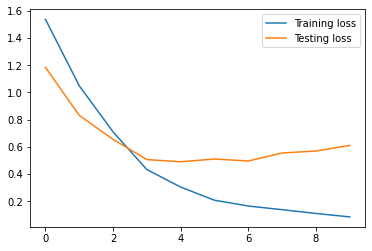

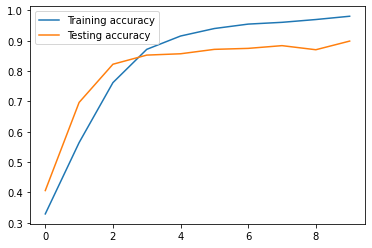

In [55]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Testing loss")
plt.legend()
plt.show()

plt.plot(train_accs, label = "Training accuracy")
plt.plot(test_accs, label = "Testing accuracy")
plt.legend()
plt.show()

In [ ]:
dataset.set_format(type="torch", columns=["text", "label-coarse"])
train_dataloader = DataLoader(dataset["train"], batch_size=256)
next(iter(train_dataloader))